In [163]:
import sys
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
print(sys.path)

# Add the full absolute path to the ephys_analysis repo
sys.path.append('/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis')

from LFP.lfp_collection import LFPCollection

['/blue/npadillacoreano/t.heeps/.conda/envs/lfp_export_env/lib/python310.zip', '/blue/npadillacoreano/t.heeps/.conda/envs/lfp_export_env/lib/python3.10', '/blue/npadillacoreano/t.heeps/.conda/envs/lfp_export_env/lib/python3.10/lib-dynload', '', '/blue/npadillacoreano/t.heeps/.conda/envs/lfp_export_env/lib/python3.10/site-packages', '/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis', '/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis', '/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis', '/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis', '/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis', '/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis', '/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis', '/blue/npadillacoreano/t.heeps/rehouse_code/ephys_analysis']


In [164]:
# Path to your saved JSON
json_path = "/home/t.heeps/blue_npadillacoreano/npadillacoreano/share/rehouse_data/lfp_collections/lfp_collection.json"

# Load the collection
lfp_collection = LFPCollection.load_collection(json_path)

# Confirm successful load
print(f"✅ Loaded {len(lfp_collection.recordings)} recordings")
print("Brain regions:", list(lfp_collection.brain_region_dict.keys()))

✅ Loaded 4 recordings
Brain regions: ['mPFC', 'NAc', 'MD', 'BLA', 'vHPC']


In [165]:
lfp_collection.preprocess()

  0%|          | 0/4 [00:00<?, ?it/s]

processing 44_rehouse_d0_merged.rec


 25%|██▌       | 1/4 [00:00<00:01,  1.66it/s]

RMS Traces calculated
processing 41_rehouse_d0_merged.rec


 50%|█████     | 2/4 [00:01<00:01,  1.98it/s]

RMS Traces calculated
processing 41_rehouse_d7_merged.rec


 75%|███████▌  | 3/4 [00:01<00:00,  2.02it/s]

RMS Traces calculated
processing 44_rehouse_d7_merged.rec


100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

RMS Traces calculated


In [166]:
lfp_collection.calculate_coherence()

 25%|██▌       | 1/4 [00:05<00:16,  5.64s/it]

Coherence calcualatd


 50%|█████     | 2/4 [00:09<00:09,  4.81s/it]

Coherence calcualatd


 75%|███████▌  | 3/4 [00:14<00:04,  4.54s/it]

Coherence calcualatd


100%|██████████| 4/4 [00:19<00:00,  4.94s/it]

Coherence calcualatd


In [167]:
for rec in lfp_collection.recordings:
    print(f"Recording: {rec.name} (Subject: {rec.subject}) — Regions: {list(rec.brain_region_dict.keys())}")


Recording: 44_rehouse_d0_merged.rec (Subject: 44) — Regions: ['BLA', 'MD', 'NAc', 'mPFC', 'vHPC']
Recording: 41_rehouse_d0_merged.rec (Subject: 41) — Regions: ['BLA', 'MD', 'NAc', 'mPFC', 'vHPC']
Recording: 41_rehouse_d7_merged.rec (Subject: 41) — Regions: ['BLA', 'MD', 'NAc', 'mPFC', 'vHPC']
Recording: 44_rehouse_d7_merged.rec (Subject: 44) — Regions: ['BLA', 'MD', 'NAc', 'mPFC', 'vHPC']


### Shape of Coherence:
coh.shape → (T, F, R, R):

T: time bins (based on window + step)

F: frequencies (based on multitaper settings)

R: brain regions (length of brain_region_dict)

In [168]:
d0_44_coh = lfp_collection.recordings[0].coherence
print(d0_44_coh.shape)

(3601, 500, 5, 5)


## Coherence now made | Loading behaviors for analysis

In [169]:
rec = lfp_collection.recordings[0]
print(rec.name)
print(rec.event_dict.keys())  # List of behavior types (e.g., 'sniffing', 'fighting', etc.)

44_rehouse_d0_merged.rec
dict_keys(['anogenital sniffing', 'chasing', 'facial sniffing', 'fighting', 'mice back in', 'mice taken out', 'sniffing object'])


### Creating time vector to allow us to put an event behavior mask over coherence

### We have one value per time window .shape[0], but we don't have a timestamp attached to thosse windows, we create it here with the timestep taking the time at the center of each window

In [170]:
def create_time_vector(rec):
    T = rec.coherence.shape[0]
    step = rec.timestep  # this is usually 0.1 or 0.5s
    tvec = np.arange(T) * step
    return tvec

In [171]:
tvec = create_time_vector(rec)
print("tvec shape:", tvec.shape)
print("Start:", tvec[0], "End:", tvec[-1])


tvec shape: (3601,)
Start: 0.0 End: 1800.0


In [172]:
def make_event_mask(tvec, event_ranges):
    """
    Create a boolean mask over `tvec` for all event time ranges.
    """
    mask = np.zeros_like(tvec, dtype=bool)
    for start, stop in event_ranges:
        mask |= (tvec >= start) & (tvec <= stop)
    return mask


In [173]:
for rec in lfp_collection.recordings:
    rec.tvec = create_time_vector(rec)
    print(rec.tvec)

[0.0000e+00 5.0000e-01 1.0000e+00 ... 1.7990e+03 1.7995e+03 1.8000e+03]
[0.0000e+00 5.0000e-01 1.0000e+00 ... 1.7990e+03 1.7995e+03 1.8000e+03]
[0.0000e+00 5.0000e-01 1.0000e+00 ... 1.7985e+03 1.7990e+03 1.7995e+03]
[0.0000e+00 5.0000e-01 1.0000e+00 ... 1.7980e+03 1.7985e+03 1.7990e+03]


In [174]:
print(f"{rec.name}:")
print(f"  - first_timestamp: {rec.first_timestamp}")
print(f"  - timestep: {rec.timestep}")
print(f"  - coherence.shape[0] = {rec.coherence.shape[0]}")
print(f"  - tvec[0:5] = {tvec[:5]}")
print(f"  - tvec[-5:] = {tvec[-5:]}")


44_rehouse_d7_merged.rec:
  - first_timestamp: 1834892
  - timestep: 0.5
  - coherence.shape[0] = 3599
  - tvec[0:5] = [0.  0.5 1.  1.5 2. ]
  - tvec[-5:] = [1798.  1798.5 1799.  1799.5 1800. ]


In [229]:
print(rec.name)

44_rehouse_d7_merged.rec


In [230]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_event_coherence(
    lfp_collection, event='sniffing object', region_from='mPFC', region_to='NAc', 
    freq_limit=100, title=None, save_path=None
):
    curves = []

    for rec in lfp_collection.recordings:
        # Skip recordings without the event
        if event not in rec.event_dict:
            continue

        region_dict = rec.brain_region_dict
        if not all(region in region_dict for region in [region_from, region_to]):
            continue

        # mask
        mask = make_event_mask(rec.tvec, rec.event_dict[event])
        if not np.any(mask):
            continue

        # Filter coherence during event
        coh_event = rec.coherence[mask]  # (T_event, F, R, R)
        avg_coh = np.nanmean(coh_event, axis=0)  # (F, R, R)

        from_idx = region_dict[region_from]
        to_idx = region_dict[region_to]
        F, R, _ = avg_coh.shape
        if from_idx >= R or to_idx >= R:
            continue

        coh_curve = avg_coh[:, from_idx, to_idx]
        freqs = rec.frequencies
        freq_mask = freqs <= freq_limit
        freqs_plot = freqs[freq_mask]
        coh_plot = coh_curve[freq_mask]

        subj = rec.subject if hasattr(rec, "subject") else rec.name.split('_')[0]
        day = 'd0' if 'd0' in rec.name else 'd7'  # optionally improve this too

        # Detect day and familiarity
        if 'd0' in rec.name.lower():
            fam = 'low fam'
            fam_short = 'low fam'
        elif 'd7' in rec.name.lower():
            fam = 'high fam'
            fam_short = 'high fam'
        else:
            fam = 'unknown fam'
            fam_short = 'unknown'

        label = f"subj {subj} - {fam_short}"
        curves.append((label, freqs_plot, coh_plot, subj, fam, rec.name))


    if not curves:
        print(f"⚠️ No valid data to plot for event '{event}' and region {region_from} - {region_to}")
        return

    subjects = sorted(set(subj for _, _, _, subj, _, _ in curves))
    cmap = plt.get_cmap('tab10', len(subjects))
    # or
    # cmap = matplotlib.colormaps['tab10']

    subject_colors = {subj: cmap(i) for i, subj in enumerate(subjects)}

    plt.figure(figsize=(10, 6))
    for label, freqs, coh, subj, fam, rec_name in curves:
        if fam!='high fam' and fam!='low fam':
            print("error in fam")
            break
        linestyle = '--' if fam == 'high fam' else '-'
        color = subject_colors[subj]
        plt.plot(freqs, coh, label=label, linewidth=1.5, linestyle=linestyle, color=color)

        print(f"➡️  {rec_name}: Subject={subj}, Day={fam}, Freq Shape={freqs.shape}, Coherence Mean={np.nanmean(coh):.3f}")




    plt.title(title if title else f"{region_from} - {region_to} Coherence during '{event}'", fontsize=20)
    plt.xlabel("Frequency (Hz)", fontsize=16)
    plt.ylabel("Coherence", fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=14)

    # Save or show
    if save_path:
        save_dir = Path(save_path)
        save_dir.mkdir(parents=True, exist_ok=True)
        filename = f"{region_from}_to_{region_to}_{event.replace(' ', '_')}.png"
        full_path = save_dir / filename
        plt.savefig(full_path)
        plt.close()
        print(f"✅ Saved: {full_path}")
    else:
        plt.show()


In [231]:
plot_event_coherence(
    lfp_collection,
    event='facial sniffing',
    region_from='mPFC',
    region_to='NAc',
    title="mPFC - NAc during 'facial sniffing'",
    save_path="/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/"
)

plot_event_coherence(
    lfp_collection,
    event='facial sniffing',
    region_from='mPFC',
    region_to='MD',
    title="mPFC - MD during 'facial sniffing'",
    save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)


/scratch/local/9419728/ipykernel_216011/1208921692.py:28: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(coh_event, axis=0)  # (F, R, R)


➡️  44_rehouse_d0_merged.rec: Subject=44, Day=low fam, Freq Shape=(101,), Coherence Mean=0.610
➡️  41_rehouse_d0_merged.rec: Subject=41, Day=low fam, Freq Shape=(101,), Coherence Mean=0.564
➡️  41_rehouse_d7_merged.rec: Subject=41, Day=high fam, Freq Shape=(101,), Coherence Mean=0.570
➡️  44_rehouse_d7_merged.rec: Subject=44, Day=high fam, Freq Shape=(101,), Coherence Mean=0.629
✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_NAc_facial_sniffing.png
➡️  44_rehouse_d0_merged.rec: Subject=44, Day=low fam, Freq Shape=(101,), Coherence Mean=0.516
➡️  41_rehouse_d0_merged.rec: Subject=41, Day=low fam, Freq Shape=(101,), Coherence Mean=0.488
➡️  41_rehouse_d7_merged.rec: Subject=41, Day=high fam, Freq Shape=(101,), Coherence Mean=0.490
➡️  44_rehouse_d7_merged.rec: Subject=44, Day=high fam, Freq Shape=(101,), Coherence Mean=0.531
✅ Saved: /home/t.heeps/blue_n

In [217]:
plot_event_coherence(
    lfp_collection,
    event='anogenital sniffing',
    region_from='mPFC',
    region_to='NAc',
    title="mPFC - NAc during 'anogenital sniffing'",
    save_path="/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/"
)

plot_event_coherence(
    lfp_collection,
    event='anogenital sniffing',
    region_from='mPFC',
    region_to='MD',
    title="mPFC - MD during 'anogenital sniffing'",
    save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)


/scratch/local/9419728/ipykernel_216011/776570679.py:28: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(coh_event, axis=0)  # (F, R, R)


✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_NAc_anogenital_sniffing.png
✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_MD_anogenital_sniffing.png


/scratch/local/9419728/ipykernel_216011/776570679.py:28: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(coh_event, axis=0)  # (F, R, R)


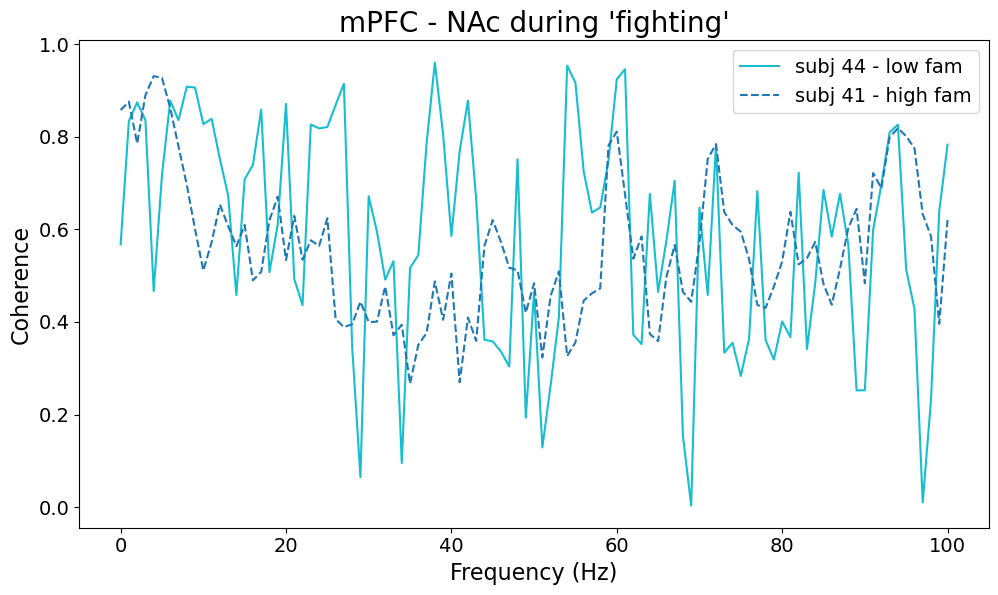

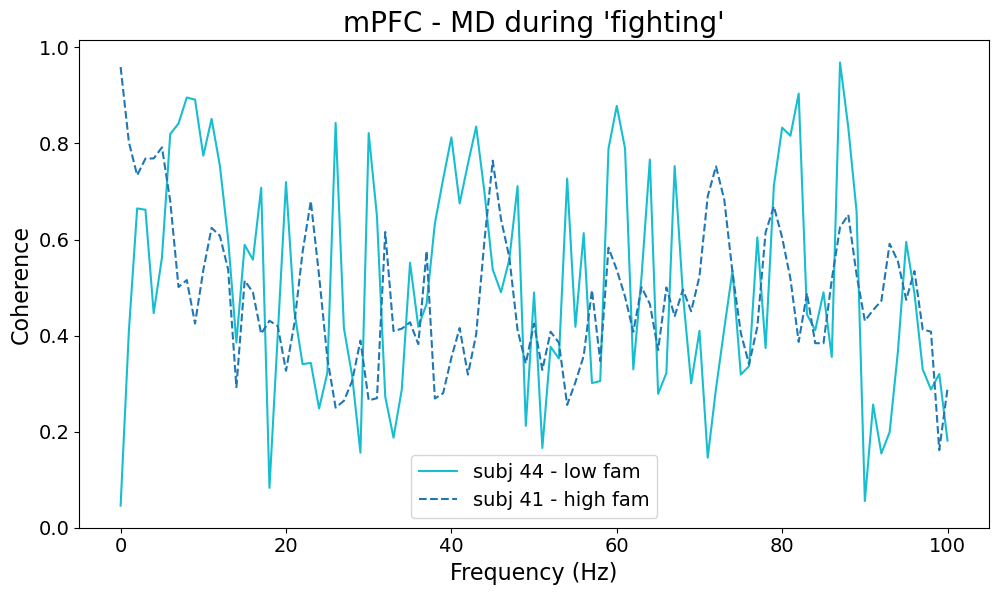

In [218]:
plot_event_coherence(
    lfp_collection,
    event='chasing',
    region_from='mPFC',
    region_to='NAc',
    title="mPFC - NAc during 'fighting'",
    # save_path="/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/"
)

plot_event_coherence(
    lfp_collection,
    event='chasing',
    region_from='mPFC',
    region_to='MD',
    title="mPFC - MD during 'fighting'",
    # save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)


/scratch/local/9419728/ipykernel_216011/776570679.py:28: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(coh_event, axis=0)  # (F, R, R)


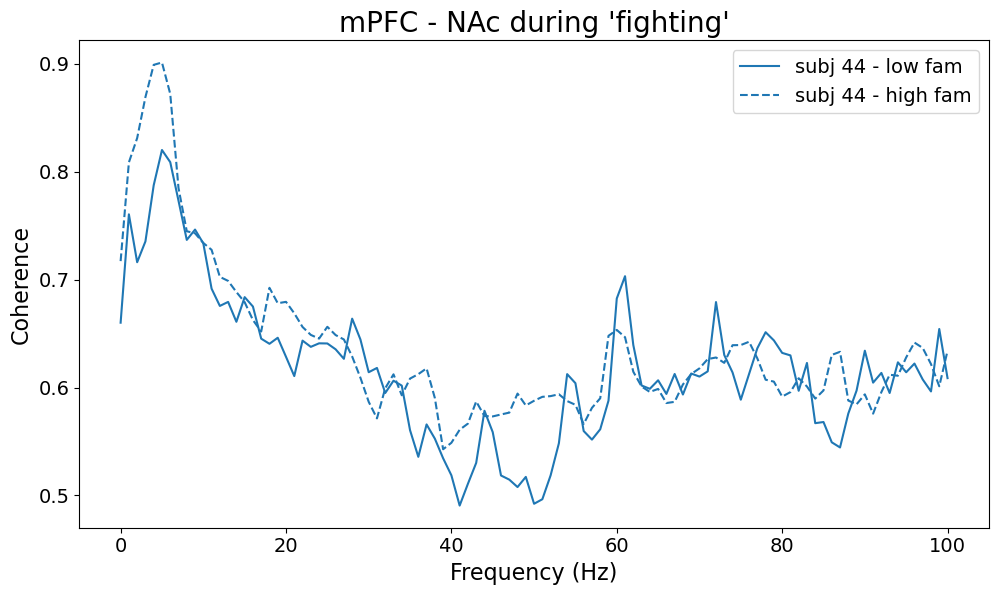

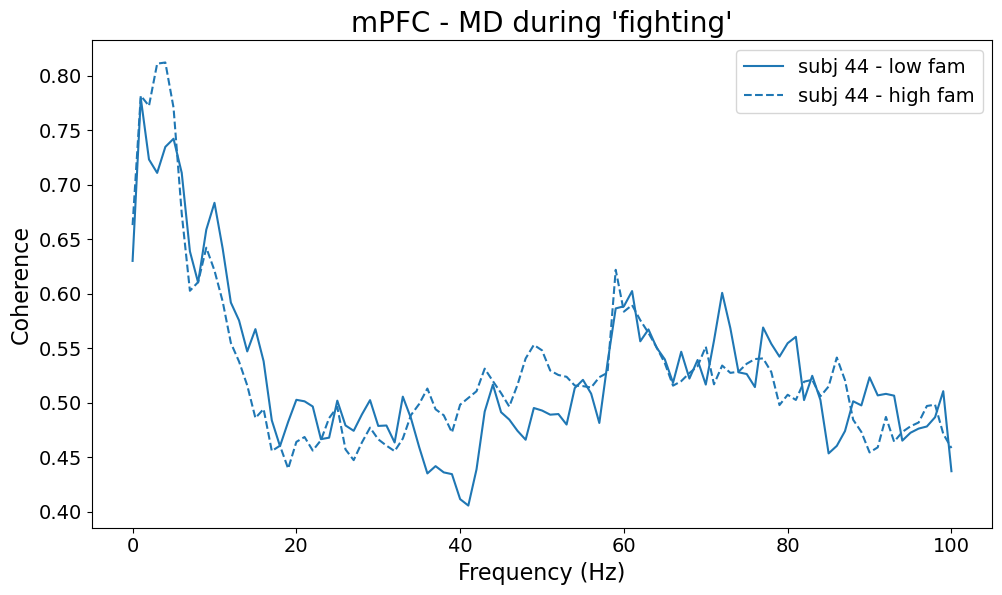

In [219]:
plot_event_coherence(
    lfp_collection,
    event='fighting',
    region_from='mPFC',
    region_to='NAc',
    title="mPFC - NAc during 'fighting'",
    # save_path="/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/"
)

plot_event_coherence(
    lfp_collection,
    event='fighting',
    region_from='mPFC',
    region_to='MD',
    title="mPFC - MD during 'fighting'",
    # save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)


In [220]:
plot_event_coherence(
    lfp_collection,
    event='sniffing object',
    region_from='mPFC',
    region_to='NAc',
    title="mPFC - NAc during 'sniffing object'",
    save_path="/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/"
)

plot_event_coherence(
    lfp_collection,
    event='sniffing object',
    region_from='mPFC',
    region_to='MD',
    title="mPFC - MD during 'sniffing object'",
    save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)


/scratch/local/9419728/ipykernel_216011/776570679.py:28: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(coh_event, axis=0)  # (F, R, R)


✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_NAc_sniffing_object.png
✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_MD_sniffing_object.png


In [251]:
def plot_event_coherence(
    lfp_collection, events='sniffing object', region_from='mPFC', region_to='NAc', 
    freq_limit=100, title=None, save_path=None
):
    if isinstance(events, str):
        events = [events]  # convert to list if single string

    curves = []

    for rec in lfp_collection.recordings:
        region_dict = rec.brain_region_dict
        if not all(region in region_dict for region in [region_from, region_to]):
            continue

        # Combine masks for all requested events
        tvec = create_time_vector(rec)
        combined_mask = np.zeros_like(tvec, dtype=bool)
        valid = False

        for event in events:
            if event in rec.event_dict:
                mask = make_event_mask(tvec, rec.event_dict[event])
                combined_mask |= mask  # logical OR
                valid = True

        if not valid or not np.any(combined_mask):
            continue

        coh_event = rec.coherence[combined_mask]  # (T_event, F, R, R)
        avg_coh = np.nanmean(coh_event, axis=0)  # (F, R, R)

        from_idx = region_dict[region_from]
        to_idx = region_dict[region_to]
        F, R, _ = avg_coh.shape
        if from_idx >= R or to_idx >= R:
            continue

        coh_curve = avg_coh[:, from_idx, to_idx]
        freqs = rec.frequencies
        freq_mask = freqs <= freq_limit
        freqs_plot = freqs[freq_mask]
        coh_plot = coh_curve[freq_mask]

        subj = rec.subject if hasattr(rec, "subject") else rec.name.split('_')[0]

        if 'd0' in rec.name.lower():
            fam = 'low fam'
        elif 'd7' in rec.name.lower():
            fam = 'high fam'
        else:
            fam = 'unknown fam'

        label = f"subj {subj} - {fam}"
        curves.append((label, freqs_plot, coh_plot, subj, fam, rec.name))

    if not curves:
        print(f"⚠️ No valid data to plot for events {events} and region {region_from} - {region_to}")
        return

    # Define hardcoded RGB colors (0–1 scale)
    low_fam_color = (1/255, 138/255, 126/255)   # d0
    high_fam_color = (100/255, 5/255, 49/255)   # d7

    plt.figure(figsize=(5.5, 5.5))
    for label, freqs, coh, subj, fam, rec_name in curves:
        if fam == 'low fam':
            color = low_fam_color
            linestyle = '-'
        elif fam == 'high fam':
            color = high_fam_color
            linestyle = '--'
        else:
            color = 'gray'
            linestyle = ':'

        plt.plot(freqs, coh, label=label, linewidth=2.5, linestyle=linestyle, color=color)
        print(f"➡️  {rec_name}: Subject={subj}, Day={fam}, Freq Shape={freqs.shape}, Coherence Mean={np.nanmean(coh):.3f}")


    event_str = ', '.join(events)
    plt.title(title if title else f"{region_from} - {region_to} Coherence during {event_str}", fontsize=18)
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.ylabel("Coherence", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(False)
    plt.ylim(0.35, 1)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=14)

    if save_path:
        save_dir = Path(save_path)
        save_dir.mkdir(parents=True, exist_ok=True)
        filename = f"{region_from}_to_{region_to}_{'_'.join(e.replace(' ', '_') for e in events)}.png"
        full_path = save_dir / filename
        plt.savefig(full_path)
        plt.close()
        print(f"✅ Saved: {full_path}")
    else:
        plt.show()


In [252]:
plot_event_coherence(
    lfp_collection,
    events=['facial sniffing', 'anogenital sniffing'],
    region_from='mPFC',
    region_to='NAc',
    title="mPFC - NAc during Social Investigation",
    save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'

)
plot_event_coherence(
    lfp_collection,
    events=['facial sniffing', 'anogenital sniffing'],
    region_from='mPFC',
    region_to='MD',
    title="mPFC - MD during Social Investigation",
    save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'

)


/scratch/local/9419728/ipykernel_216011/453750533.py:30: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(coh_event, axis=0)  # (F, R, R)


➡️  44_rehouse_d0_merged.rec: Subject=44, Day=low fam, Freq Shape=(101,), Coherence Mean=0.601
➡️  41_rehouse_d0_merged.rec: Subject=41, Day=low fam, Freq Shape=(101,), Coherence Mean=0.564
➡️  41_rehouse_d7_merged.rec: Subject=41, Day=high fam, Freq Shape=(101,), Coherence Mean=0.567
➡️  44_rehouse_d7_merged.rec: Subject=44, Day=high fam, Freq Shape=(101,), Coherence Mean=0.633
✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_NAc_facial_sniffing_anogenital_sniffing.png
➡️  44_rehouse_d0_merged.rec: Subject=44, Day=low fam, Freq Shape=(101,), Coherence Mean=0.514
➡️  41_rehouse_d0_merged.rec: Subject=41, Day=low fam, Freq Shape=(101,), Coherence Mean=0.493
➡️  41_rehouse_d7_merged.rec: Subject=41, Day=high fam, Freq Shape=(101,), Coherence Mean=0.488
➡️  44_rehouse_d7_merged.rec: Subject=44, Day=high fam, Freq Shape=(101,), Coherence Mean=0.533
✅ Saved: 

In [260]:
def plot_event_coherence_avg_fam(
    lfp_collection, events='sniffing object', region_from='mPFC', region_to='NAc', 
    freq_limit=100, title=None, save_path=None
):
    if isinstance(events, str):
        events = [events]

    # Gather all coherence curves for each fam across subjects
    subj_data = defaultdict(list)
    freqs_plot = None  # For use in plotting

    for rec in lfp_collection.recordings:
        region_dict = rec.brain_region_dict
        if not all(region in region_dict for region in [region_from, region_to]):
            continue

        tvec = create_time_vector(rec)
        combined_mask = np.zeros_like(tvec, dtype=bool)
        valid = False

        for event in events:
            if event in rec.event_dict:
                mask = make_event_mask(tvec, rec.event_dict[event])
                combined_mask |= mask
                valid = True

        if not valid or not np.any(combined_mask):
            continue

        coh_event = rec.coherence[combined_mask]  # (T_event, F, R, R)
        avg_coh = np.nanmean(coh_event, axis=0)   # (F, R, R)

        from_idx = region_dict[region_from]
        to_idx = region_dict[region_to]
        F, R, _ = avg_coh.shape
        if from_idx >= R or to_idx >= R:
            continue

        coh_curve = avg_coh[:, from_idx, to_idx]
        freqs = rec.frequencies
        freq_mask = freqs <= freq_limit
        freqs_plot = freqs[freq_mask]
        coh_plot = coh_curve[freq_mask]

        # Figure out familiarity condition
        if 'd0' in rec.name.lower():
            fam = 'low fam'
        elif 'd7' in rec.name.lower():
            fam = 'high fam'
        else:
            fam = 'unknown fam'

        subj_data[fam].append(coh_plot)

    if not subj_data:
        print(f"⚠️ No valid data to plot for events {events} and region {region_from} - {region_to}")
        return

    # --- Define colors ---
    low_fam_color = (1/255, 138/255, 126/255)
    high_fam_color = (100/255, 5/255, 49/255)

    plt.figure(figsize=(5.5, 5.5))

    # --- Plot two lines: avg low fam, avg high fam ---
    for fam, curves in subj_data.items():
        coh_array = np.stack(curves, axis=0)  # (N_total_rec, F)
        mean_coh = np.nanmean(coh_array, axis=0)

        if fam == 'low fam':
            color = low_fam_color
            linestyle = '-'
        elif fam == 'high fam':
            color = high_fam_color
            linestyle = '-'
        else:
            color = 'gray'
            linestyle = ':'

        label = f"{fam}"
        plt.plot(freqs_plot, mean_coh, label=label, linewidth=2.5, linestyle=linestyle, color=color)
        print(f"📊 Averaged {fam}: {coh_array.shape[0]} recordings, Mean coherence = {np.nanmean(mean_coh):.3f}")

    # --- Pretty up plot ---
    event_str = ', '.join(events)
    plt.title(title if title else f"{region_from} - {region_to} Coherence during {event_str}", fontsize=18)
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.ylabel("Coherence", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.ylim(0.35, 1)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=14)

    # --- Save or show ---
    if save_path:
        save_dir = Path(save_path)
        save_dir.mkdir(parents=True, exist_ok=True)
        filename = f"{region_from}_to_{region_to}_avgfam_{'_'.join(e.replace(' ', '_') for e in events)}.png"
        full_path = save_dir / filename
        plt.savefig(full_path)
        plt.close()
        print(f"✅ Saved: {full_path}")
    else:
        plt.show()


In [262]:
plot_event_coherence_avg_fam(
    lfp_collection,
    events=['facial sniffing', 'anogenital sniffing'],
    region_from='mPFC',
    region_to='NAc',
    title="mPFC - NAc during Social Investigation",
    save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'

)
plot_event_coherence_avg_fam(
    lfp_collection,
    events=['facial sniffing', 'anogenital sniffing'],
    region_from='mPFC',
    region_to='MD',
    title="mPFC - MD during Social Investigation",
    save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'

)


/scratch/local/9419728/ipykernel_216011/3365347403.py:31: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(coh_event, axis=0)   # (F, R, R)


📊 Averaged low fam: 2 recordings, Mean coherence = 0.583
📊 Averaged high fam: 2 recordings, Mean coherence = 0.600
✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_NAc_avgfam_facial_sniffing_anogenital_sniffing.png
📊 Averaged low fam: 2 recordings, Mean coherence = 0.504
📊 Averaged high fam: 2 recordings, Mean coherence = 0.510
✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_MD_avgfam_facial_sniffing_anogenital_sniffing.png


In [103]:
!jupyter nbconvert --to script coherence_41_44.ipynb

[NbConvertApp] Converting notebook coherence_41_44.ipynb to script
[NbConvertApp] Writing 17246 bytes to coherence_41_44.py


### Directionality plots for ***mpfc*** -> ***nac*** and ***mpfc*** -> ***md***

In [50]:
def coh_plot(rec, freqs, mpfc_to_nac, mpfc_to_md, save_dir=None):
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mpfc_to_nac, label='mPFC → NAc', color='blue')
    plt.plot(freqs, mpfc_to_md, label='mPFC → MD', color='green')
    plt.title(f"Average Coherence Directionality — {rec.name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Coherence")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_dir is not None:
        # Safe file name
        fname = f"coh_{rec.name.replace('.rec','')}.png"
        plt.savefig(os.path.join(save_dir, fname))
        plt.close()
    else:
        plt.show()

In [51]:
# Pick a recording to visualize
d0_44 = lfp_collection.recordings[0]

In [52]:
# Get region indices
region_dict = d0_44.brain_region_dict
mpfc_idx = region_dict['mPFC']
nac_idx = region_dict['NAc']
md_idx = region_dict['MD']

### Get Average, spectra for each direction, slice freqs 

In [53]:
# Average over time (T axis)
avg_coh = np.nanmean(d0_44.coherence, axis=0)  # shape: (F, R, R)

# Get coherence spectra for each direction
mpfc_to_nac = avg_coh[:, mpfc_idx, nac_idx]
mpfc_to_md = avg_coh[:, mpfc_idx, md_idx]

# Slice to 0–100 Hz only
freqs = d0_44.frequencies  # full frequency vector, e.g., 0–500 Hz
freq_mask = freqs <= 100
freqs = freqs[freq_mask]
mpfc_to_nac = mpfc_to_nac[freq_mask]
mpfc_to_md = mpfc_to_md[freq_mask]

/scratch/local/9419728/ipykernel_216011/2152753303.py:2: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(d0_44.coherence, axis=0)  # shape: (F, R, R)


In [54]:
print("avg_coh shape:", avg_coh.shape)
print("brain regions in recording:", rec.brain_region_dict)
print("mpfc_idx:", mpfc_idx, "nac_idx:", nac_idx, "bla_idx:", rec.brain_region_dict.get("BLA", "not found"))


avg_coh shape: (500, 5, 5)
brain regions in recording: bidict({'BLA': 3, 'MD': 2, 'NAc': 1, 'mPFC': 0, 'vHPC': 4})
mpfc_idx: 0 nac_idx: 1 bla_idx: 3


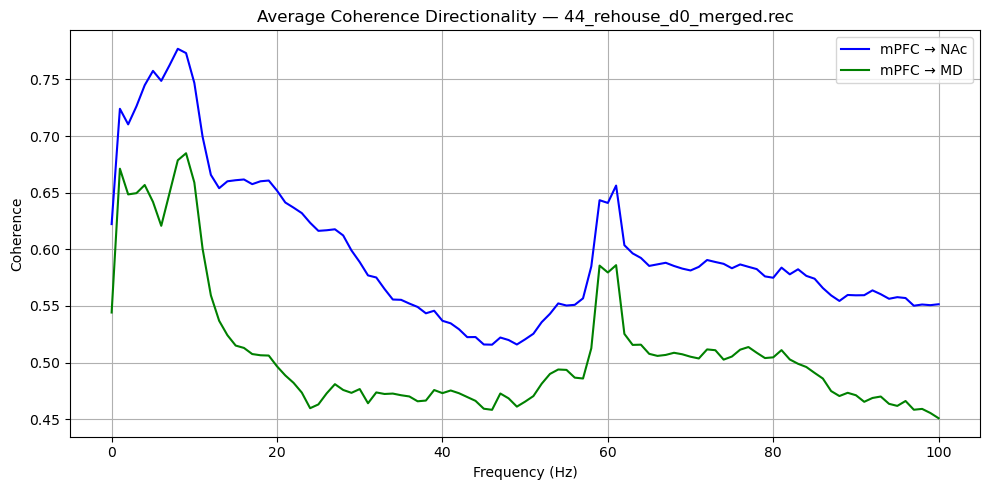

In [55]:
# Plot
coh_plot(d0_44, freqs, mpfc_to_nac, mpfc_to_md)

### Plots of 4.1 and 4.4 coherence directionality mpfc -> nac and mpfc -> MD

In [56]:
for rec in lfp_collection.recordings:
    print(f"Processing {rec.name}")
    region_dict = rec.brain_region_dict

    # Skip if any region is missing (shouldn't happen with your recordings)
    if not all(region in region_dict for region in ['mPFC', 'NAc', 'MD']):
        print(f"Skipping {rec.name}: required regions not found.")
        continue

    mpfc_idx = region_dict['mPFC']
    nac_idx = region_dict['NAc']
    md_idx = region_dict['MD']

    avg_coh = np.nanmean(rec.coherence, axis=0)  # (F, R, R)
    mpfc_to_nac = avg_coh[:, mpfc_idx, nac_idx]
    mpfc_to_md = avg_coh[:, mpfc_idx, md_idx]

    # Frequency restriction
    freqs = rec.frequencies
    freq_mask = freqs <= 100
    freqs_plot = freqs[freq_mask]
    mpfc_to_nac_plot = mpfc_to_nac[freq_mask]
    mpfc_to_md_plot = mpfc_to_md[freq_mask]

    # Plot (and/or save)
    coh_plot(
        rec, 
        freqs_plot, 
        mpfc_to_nac_plot, 
        mpfc_to_md_plot,
        save_dir='/home/t.heeps/blue_npadillacoreano/rehouse_code/coherence_plots/plots',
    )

Processing 44_rehouse_d0_merged.rec


/scratch/local/9419728/ipykernel_216011/2231502305.py:14: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(rec.coherence, axis=0)  # (F, R, R)


Processing 41_rehouse_d0_merged.rec
Processing 41_rehouse_d7_merged.rec
Processing 44_rehouse_d7_merged.rec


/scratch/local/9419728/ipykernel_216011/3628726135.py:15: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(rec.coherence, axis=0)  # (F, R, R)


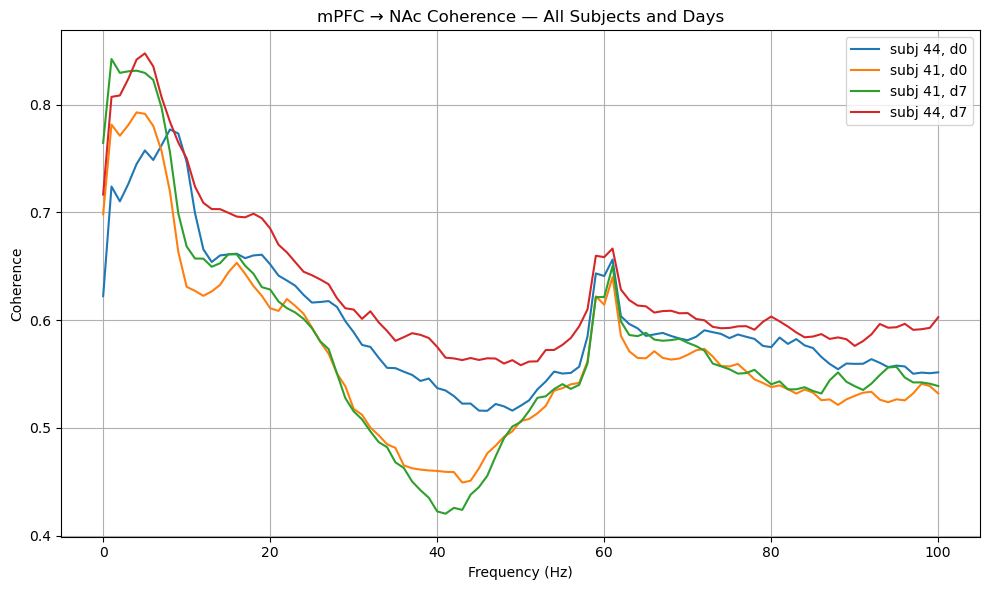

In [57]:
# Collect all mPFC-NAc curves for each (subject, day)
curves = []  # Each item: (label, freqs, coherence)

for rec in lfp_collection.recordings:
    region_dict = rec.brain_region_dict
    if not all(region in region_dict for region in ['mPFC', 'NAc']):
        continue

    # Subject and day — adjust as needed based on your actual attributes
    subj = rec.subject if hasattr(rec, "subject") else rec.name.split('_')[0]
    day = 'd0' if 'd0' in rec.name else 'd7' if 'd7' in rec.name else 'UNK'

    mpfc_idx = region_dict['mPFC']
    nac_idx = region_dict['NAc']
    avg_coh = np.nanmean(rec.coherence, axis=0)  # (F, R, R)
    mpfc_to_nac = avg_coh[:, mpfc_idx, nac_idx]

    freqs = rec.frequencies
    freq_mask = freqs <= 100
    freqs_plot = freqs[freq_mask]
    mpfc_to_nac_plot = mpfc_to_nac[freq_mask]

    label = f"subj {subj}, {day}"
    curves.append((label, freqs_plot, mpfc_to_nac_plot))

# Plot all on one figure
plt.figure(figsize=(10, 6))
for label, freqs, coh in curves:
    plt.plot(freqs, coh, label=label)
plt.title("mPFC → NAc Coherence — All Subjects and Days")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Coherence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Optionally save:
# plt.savefig('mpfc_nac_all_subjects_days.png')
# plt.close()


In [58]:
for rec in lfp_collection.recordings:
    print(f"Recording: {rec.name} (Subject: {rec.subject}) — Regions: {list(rec.brain_region_dict.keys())}")


Recording: 44_rehouse_d0_merged.rec (Subject: 44) — Regions: ['BLA', 'MD', 'NAc', 'mPFC', 'vHPC']
Recording: 41_rehouse_d0_merged.rec (Subject: 41) — Regions: ['BLA', 'MD', 'NAc', 'mPFC', 'vHPC']
Recording: 41_rehouse_d7_merged.rec (Subject: 41) — Regions: ['BLA', 'MD', 'NAc', 'mPFC', 'vHPC']
Recording: 44_rehouse_d7_merged.rec (Subject: 44) — Regions: ['BLA', 'MD', 'NAc', 'mPFC', 'vHPC']


In [ ]:
print("🔍 Verifying brain region integrity for each recording...\n")
for rec in lfp_collection.recordings:
    region_dict = rec.brain_region_dict
    region_names = list(region_dict.keys())

    coh_shape = rec.coherence.shape  # (T, F, R, R)
    T, F, R, _ = coh_shape

    # Reverse mapping: index to region (e.g., 0 → 'mPFC')
    reverse_map = {v: k for k, v in region_dict.items()}
    region_list_from_indices = [reverse_map.get(i, 'MISSING') for i in range(R)]

    print(f"📁 {rec.name} (Subject: {rec.subject})")
    print(f"  - Regions in dict:      {region_names}")
    print(f"  - Coherence shape:      {coh_shape}")
    print(f"  - Region count (R):     {R}")
    print(f"  - Regions by index map: {region_list_from_indices}")
    print(f"  - Missing regions:      {[r for r in ['mPFC','NAc','MD','vHPC','BLA'] if r not in region_names]}")
    print()


In [65]:
for recs in lfp_collection.recordings:
    print(f"{recs.name}, {recs.event_dict.keys()}")

44_rehouse_d0_merged.rec, dict_keys(['anogenital sniffing', 'chasing', 'facial sniffing', 'fighting', 'mice back in', 'mice taken out', 'sniffing object'])
41_rehouse_d0_merged.rec, dict_keys(['anogenital sniffing', 'facial sniffing', 'mice back in', 'mice taken out', 'sniffing object'])
41_rehouse_d7_merged.rec, dict_keys(['anogenital sniffing', 'chasing', 'facial sniffing', 'mice back in', 'mice taken out', 'sniffing object'])
44_rehouse_d7_merged.rec, dict_keys(['anogenital sniffing', 'facial sniffing', 'fighting', 'mice back in', 'mice taken out', 'sniffing object'])


### Plotting d0 and d7 rec together comparing coherence difference

/scratch/local/9419728/ipykernel_216011/3426632245.py:18: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(rec.coherence, axis=0)  # (F, R, R)


✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_NAc.png
✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_MD.png


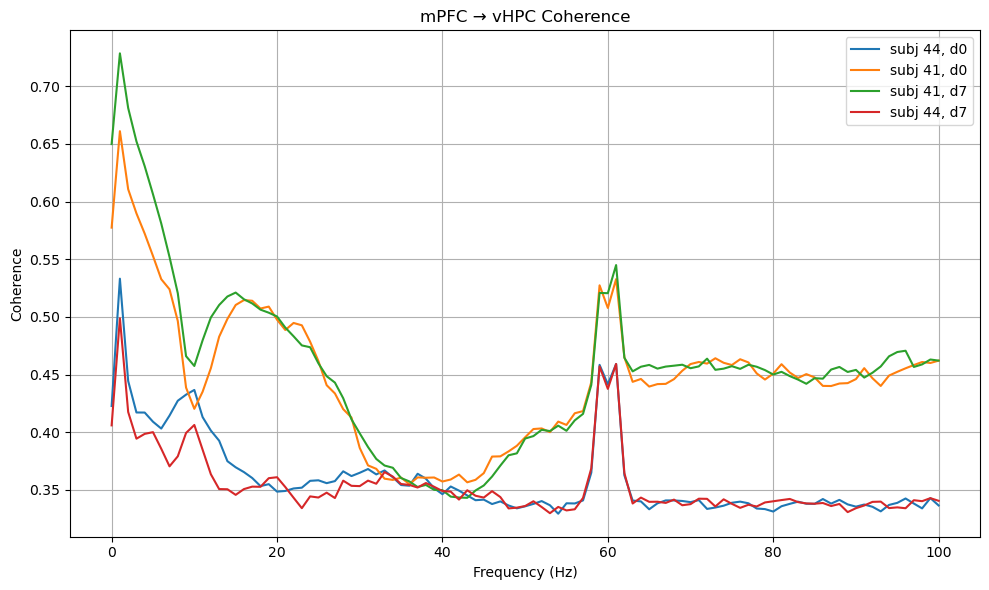

⚠️ Skipping 41_rehouse_d0_merged.rec: index (0, 4) out of bounds for R=4
⚠️ Skipping 41_rehouse_d7_merged.rec: index (0, 4) out of bounds for R=4


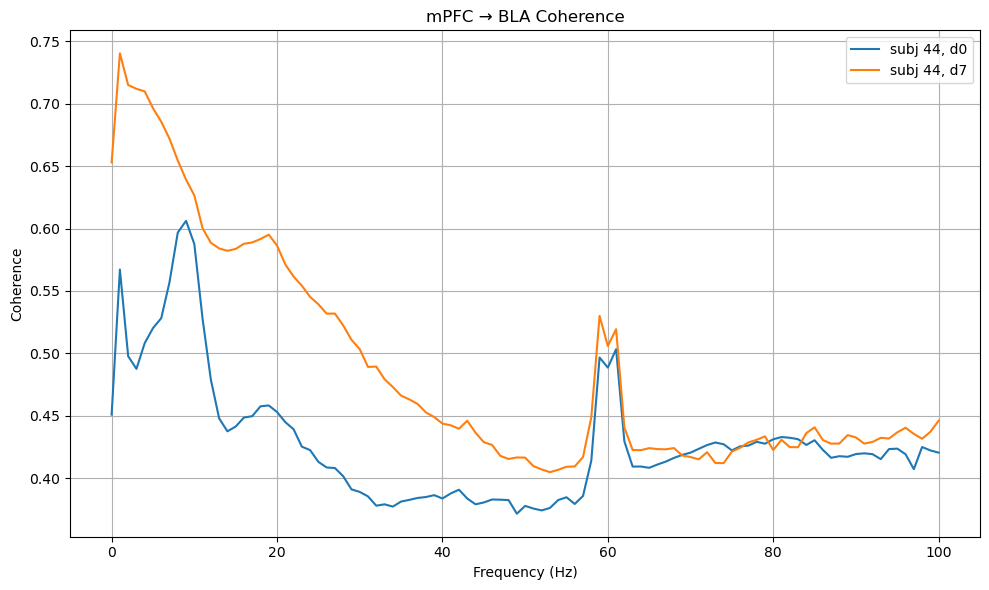

In [32]:
from pathlib import Path

def plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='NAc', 
    freq_limit=100, title=None, save_path=None
):
    curves = []
    for rec in lfp_collection.recordings:
        region_dict = rec.brain_region_dict

        # Skip if either region missing in dictionary
        if not all(region in region_dict for region in [region_from, region_to]):
            continue

        from_idx = region_dict[region_from]
        to_idx = region_dict[region_to]

        avg_coh = np.nanmean(rec.coherence, axis=0)  # (F, R, R)
        _, R, _ = avg_coh.shape
        if from_idx >= R or to_idx >= R:
            print(f"⚠️ Skipping {rec.name}: index ({from_idx}, {to_idx}) out of bounds for R={R}")
            continue

        subj = rec.subject if hasattr(rec, "subject") else rec.name.split('_')[0]
        day = 'd0' if 'd0' in rec.name else 'd7' if 'd7' in rec.name else 'UNK'

        coh_curve = avg_coh[:, from_idx, to_idx]

        freqs = rec.frequencies
        freq_mask = freqs <= freq_limit
        freqs_plot = freqs[freq_mask]
        coh_plot = coh_curve[freq_mask]

        label = f"subj {subj}, {day}"
        curves.append((label, freqs_plot, coh_plot))

    if not curves:
        print(f"⚠️ No valid data to plot for {region_from} - {region_to}")
        return

    # Plot
    plt.figure(figsize=(10, 6))
    for label, freqs, coh in curves:
        plt.plot(freqs, coh, label=label)
    plt.title(title if title else f"{region_from} - {region_to} Coherence — All Subjects and Days")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Coherence")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save to file
    if save_path:
        # Ensure directory exists
        save_dir = Path(save_path)
        save_dir.mkdir(parents=True, exist_ok=True)
        filename = f"{region_from}_to_{region_to}.png"
        full_path = save_dir / filename
        plt.savefig(full_path)
        plt.close()
        print(f"✅ Saved: {full_path}")
    else:
        plt.show()


# Example usage
plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='NAc', save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)
plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='MD', save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)
plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='vHPC', title="mPFC → vHPC Coherence"
)
plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='BLA', title="mPFC → BLA Coherence"
)

/scratch/local/9419728/ipykernel_216011/355235746.py:22: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(rec.coherence, axis=0)  # (F, R, R)
/scratch/local/9419728/ipykernel_216011/355235746.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(subjects))  # or 'Set1', 'tab20', etc.


✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_NAc_color_same.png
✅ Saved: /home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/mPFC_to_MD_color_same.png


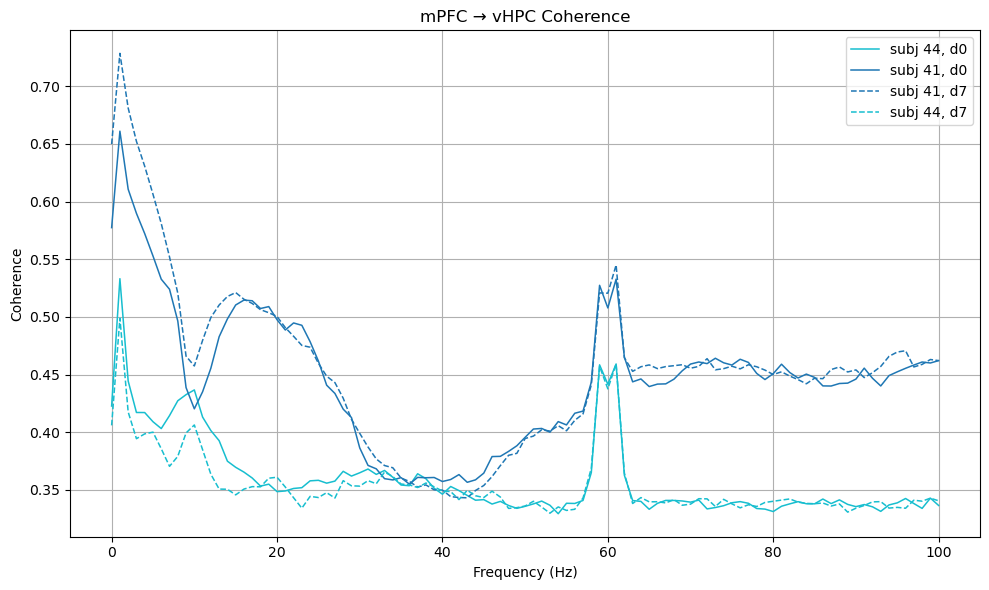

In [40]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import defaultdict

def plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='NAc', 
    freq_limit=100, title=None, save_path=None
):
    curves = []
    for rec in lfp_collection.recordings:
        region_dict = rec.brain_region_dict

        # Skip if either region missing in dictionary
        if not all(region in region_dict for region in [region_from, region_to]):
            continue

        from_idx = region_dict[region_from]
        to_idx = region_dict[region_to]

        avg_coh = np.nanmean(rec.coherence, axis=0)  # (F, R, R)
        _, R, _ = avg_coh.shape
        if from_idx >= R or to_idx >= R:
            print(f"⚠️ Skipping {rec.name}: index ({from_idx}, {to_idx}) out of bounds for R={R}")
            continue

        subj = rec.subject if hasattr(rec, "subject") else rec.name.split('_')[0]
        day = 'd0' if 'd0' in rec.name else 'd7' if 'd7' in rec.name else 'UNK'

        coh_curve = avg_coh[:, from_idx, to_idx]

        freqs = rec.frequencies
        freq_mask = freqs <= freq_limit
        freqs_plot = freqs[freq_mask]
        coh_plot = coh_curve[freq_mask]

        label = f"subj {subj}, {day}"
        curves.append((label, freqs_plot, coh_plot))

    if not curves:
        print(f"⚠️ No valid data to plot for {region_from} - {region_to}")
        return


    # Extract unique subject IDs
    subjects = sorted(set(label.split(',')[0].split()[-1] for label, _, _ in curves))
    
    # Generate color map
    cmap = cm.get_cmap('tab10', len(subjects))  # or 'Set1', 'tab20', etc.
    subject_colors = {subj: cmap(i) for i, subj in enumerate(subjects)}

    plt.figure(figsize=(10, 6))

    for label, freqs, coh in curves:
        subj = label.split(',')[0].split()[-1]
        day = label.split(',')[1].strip()

        linestyle = '--' if day == 'd7' else '-'
        color = subject_colors[subj]

        plt.plot(freqs, coh, label=label, linewidth=1.1, linestyle=linestyle, color=color)

    plt.title(title if title else f"{region_from} - {region_to} Coherence — All Subjects and Days")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Coherence")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save or show the plot
    if save_path:
        save_dir = Path(save_path)
        save_dir.mkdir(parents=True, exist_ok=True)
        filename = f"{region_from}_to_{region_to}_color_same.png"
        full_path = save_dir / filename
        plt.savefig(full_path)
        plt.close()
        print(f"✅ Saved: {full_path}")
    else:
        plt.show()


# Example usage
plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='NAc', save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)
plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='MD', save_path=r'/home/t.heeps/blue_npadillacoreano/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/npadillacoreano/t.heeps/rehouse_code/coherence_plots/plots/'
)
plot_coherence_between_regions(
    lfp_collection, region_from='mPFC', region_to='vHPC', title="mPFC → vHPC Coherence"
)

### Filtering coherence data to only include coherence during the tone

In [22]:
!jupyter nbconvert --to script coherence_41_44.ipynb

[NbConvertApp] Converting notebook coherence_41_44.ipynb to script
[NbConvertApp] Writing 7972 bytes to coherence_41_44.py


In [54]:
print(dir(d0_44))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__interpolate_coherence_granger__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_selected_traces', '_read_trodes', 'brain_region_dict', 'calculate_all', 'calculate_coherence', 'calculate_granger_causality', 'calculate_power', 'channel_dict', 'coherence', 'connectivity', 'elec_noise_freq', 'event_dict', 'exclude_regions', 'export_trodes_timestamps', 'find_start_recording_time', 'first_timestamp', 'frequencies', 'get_all_channels', 'halfbandwidth', 'interpolate_coherence', 'interpolate_granger', 'interpolate_power', 'load_rec_from_h5', 'max_freq', 'merged_rec_path', 'min_freq', 'name', 'plot_all_channels', 'plot_to_find_threshold', 'preprocess', 'rec_length', 'rec_path', 'resample_rate'

In [55]:
d0_44.event_dict

{'anogenital sniffing': array([[ 606.667,  617.8  ],
        [ 607.6  ,  611.933],
        [ 618.333,  626.467],
        [ 627.267,  629.533],
        [ 630.067,  633.467],
        [ 635.133,  636.467],
        [ 643.2  ,  643.532],
        [ 648.067,  648.4  ],
        [ 650.267,  657.533],
        [ 650.467,  653.667],
        [ 659.733,  661.399],
        [ 663.667,  663.933],
        [ 668.533,  668.866],
        [ 679.667,  681.666],
        [ 689.4  ,  692.6  ],
        [ 689.467,  691.132],
        [ 692.333,  702.467],
        [ 693.267,  694.467],
        [ 701.267,  701.6  ],
        [ 706.   ,  706.8  ],
        [ 745.333,  745.866],
        [ 746.667,  748.199],
        [ 749.   ,  754.8  ],
        [ 798.067,  801.132],
        [ 811.8  ,  812.067],
        [ 871.733,  873.267],
        [ 876.867,  877.533],
        [ 878.267,  880.533],
        [ 882.067,  889.532],
        [ 890.933,  892.599],
        [ 894.867,  895.266],
        [ 928.133,  929.199],
        [1007.4  

In [48]:
!jupyter nbconvert --to script coherence_41_44.ipynb

[NbConvertApp] Converting notebook coherence_41_44.ipynb to script
[NbConvertApp] Writing 3288 bytes to coherence_41_44.py
